## Libraries

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


## Linear Regeression 


Linear regression is a statistical method used to model the relationship between a dependent variable and one or more independent variables by fitting a linear equation to observed data. The central premise is to determine a linear line that best predicts the dependent variable based on the independent variables. This line is represented by the equation Y = a + bX + ε, where Y is the dependent variable, X is the independent variable, a is the intercept, b is the slope of the line, and ε is the error term, accounting for the variance in Y not explained by X. In simple linear regression, there's only one independent variable, and the method aims to find the line that minimizes the differences (or errors) between the observed and predicted values of the dependent variable. This technique is widely used in forecasting, risk management, and finding trends from data, making it a fundamental tool in fields ranging from economics to machine learning.



##  1. Load Data

In [2]:
df = pd.read_csv('../data/medical_insurance.csv')
df = pd.DataFrame(df)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Check for Null Values

In [30]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Visualize Data

Text(0.5, 1.0, 'Age distribution')

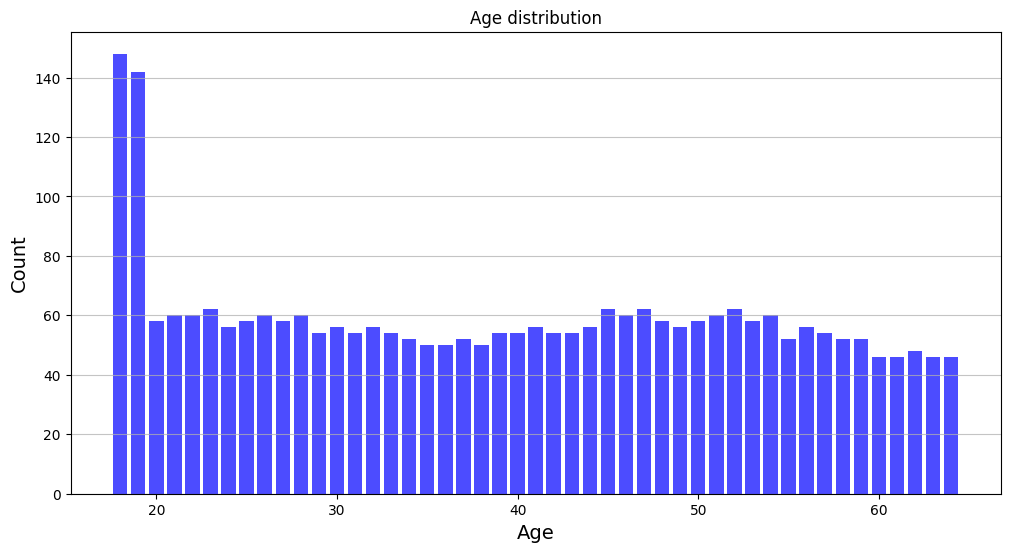

In [27]:
# AGE 
plt.figure(figsize=(12,6))
plt.bar(df.groupby('age').size().index, df.groupby('age').size().values, color='blue', alpha=0.7)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.title('Age distribution')


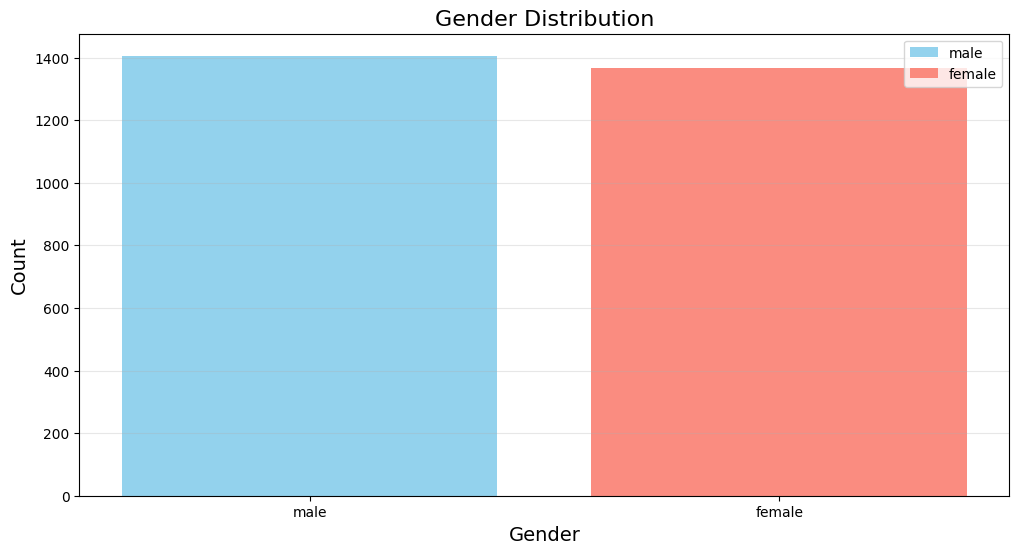

In [31]:
# Gender 

plt.figure(figsize=(12,6))
colors = ['skyblue', 'salmon']

bars = plt.bar(df['sex'].value_counts().index, df['sex'].value_counts().values, color=colors, alpha=0.9)

plt.grid(axis='y', alpha=0.3)

plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Gender Distribution', fontsize=16)

plt.legend(bars, df['sex'].value_counts().index)

plt.show()

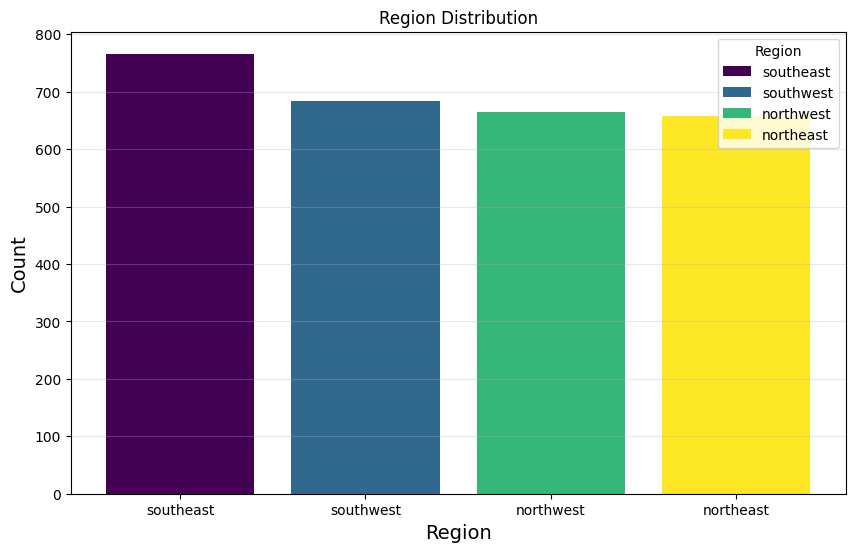

In [25]:
# Regional distribution
df_region = df['region'].value_counts().reset_index()
df_region.columns = ['region', 'count']

plt.figure(figsize=(10, 6))

unique_regions = df_region['region'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_regions)))
color_dict = dict(zip(unique_regions, colors))

for region in unique_regions:
    plt.bar(region, df_region[df_region['region'] == region]['count'], 
            color=color_dict[region], label=region)

plt.xlabel('Region', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Region Distribution')
plt.grid(axis='y', alpha=0.3)

plt.legend(title='Region')

plt.show()

In [32]:
# Define the target variable and explore it 
TARGET = 'charges'
FEATURES = df[['age', 'age', 'bmi', 'children', 'smoker', 'region']]
df = pd.concat([df[TARGET], FEATURES], axis=1)
df[TARGET].describe()

count     2772.000000
mean     13261.369959
std      12151.768945
min       1121.873900
25%       4687.797000
50%       9333.014350
75%      16577.779500
max      63770.428010
Name: charges, dtype: float64

## 2.Preprocessing

### 2.1 Categorical Columns

In [33]:
df_categorical = df.select_dtypes(include=['object'])
df_dummies = pd.get_dummies(df_categorical, drop_first=True)
print(df_dummies.head())

   smoker_yes  region_northwest  region_southeast  region_southwest
0        True             False             False              True
1       False             False              True             False
2       False             False              True             False
3       False              True             False             False
4       False              True             False             False


### 2.2 Numerical Columns

In [34]:
df_numerical = df.select_dtypes(include=['int64', 'float64'])
df_numerical.head()

,charges,age,age,bmi,children
0,16884.92400,19,19,27.900,0
1,1725.55230,18,18,33.770,1
2,4449.46200,28,28,33.000,3
3,21984.47061,33,33,22.705,0
4,3866.85520,32,32,28.880,0


In [36]:
X_num = df_numerical.drop(TARGET, axis=1)
X_scaler = StandardScaler()
X_num_scaled = X_scaler.fit_transform(X_num.values.reshape(-1, 4))
X_num_scaled = pd.DataFrame(X_num_scaled, columns=X_num.columns)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(df[[TARGET]].values.reshape(-1, 1))
y_scaled = pd.DataFrame(y_scaled, columns=[TARGET])

X = pd.concat([X_num_scaled, df_dummies], axis=1)
y = y_scaled

## 3. Model

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train.astype(float)).fit()

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
y_test_inv = y_scaler.inverse_transform(y_test)

pred_scaled = pd.DataFrame(y_pred, columns=[TARGET])
y_pred_original = y_scaler.inverse_transform(pred_scaled)

mse = mean_squared_error(y_test_inv, y_pred_original)
mae = mean_absolute_error(y_test_inv, y_pred_original)

r2, mse, mae

(0.7395573991757773, 39972979.663927875, 4163.7598447359)

In [38]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     843.6
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:46:52   Log-Likelihood:                -1582.0
No. Observations:                2217   AIC:                             3182.
Df Residuals:                    2208   BIC:                             3233.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3511      0.022    -15.702      0.000      -0.395      -0.307
age               8.864e+11   1.83e+12      0.484      0.628    -2.7e+12    4.47e+12
age              -8.864e+11   1.83e+12     -0.484      0.628   -4.47e+12     2.7e+12
bmi                  0.1647      0.011     14.836      0.000       0.143       0.186
children             0.0457      0.011      4.315      0.000       0.025       0.066
smoker_yes           1.9648      0.026     75.668      0.000       1.914       2.016
region_northwest    -0.0333      0.030     -1.100      0.271      -0.093       0.026
region_southeast    -0.0948      0.030     -3.109      0.002      -0.155      -0.035
region_southwest    -0.0872      0.030     -2.875      0.004      -0.147      -0.028
==============================================================================
Omnibus:                      478.077   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1139.800
Skew:                           1.183   Prob(JB):                    3.13e-248
Kurtosis:                       5.596   Cond. No.                     3.47e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.66e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 4. Predict on all data

In [39]:
X = sm.add_constant(X)
pred = model.predict(X)
pred_scaled = pd.DataFrame(pred, columns=[TARGET])
y_pred_original = y_scaler.inverse_transform(pred_scaled)
y_pred_original = pd.DataFrame(y_pred_original, columns=[TARGET])

df_new = df.copy()
df_new['pred'] = y_pred_original
df_new

,charges,age,age,bmi,children,smoker,region,pred
0,16884.92400,19,19,27.900,0,yes,southwest,25477.707202
1,1725.55230,18,18,33.770,1,no,southeast,3641.184293
2,4449.46200,28,28,33.000,3,no,southeast,6745.748539
3,21984.47061,33,33,22.705,0,no,northwest,3983.685217
4,3866.85520,32,32,28.880,0,no,northwest,5755.113771
...,...,...,...,...,...,...,...,...
2767,8569.86180,47,47,45.320,1,no,southeast,14497.787774
2768,2020.17700,21,21,34.600,0,no,southwest,4280.537743
2769,16450.89470,19,19,26.030,1,yes,northwest,25978.577883
2770,21595.38229,23,23,18.715,0,no,northwest,238.278228


## Forecasts vs. Predicted

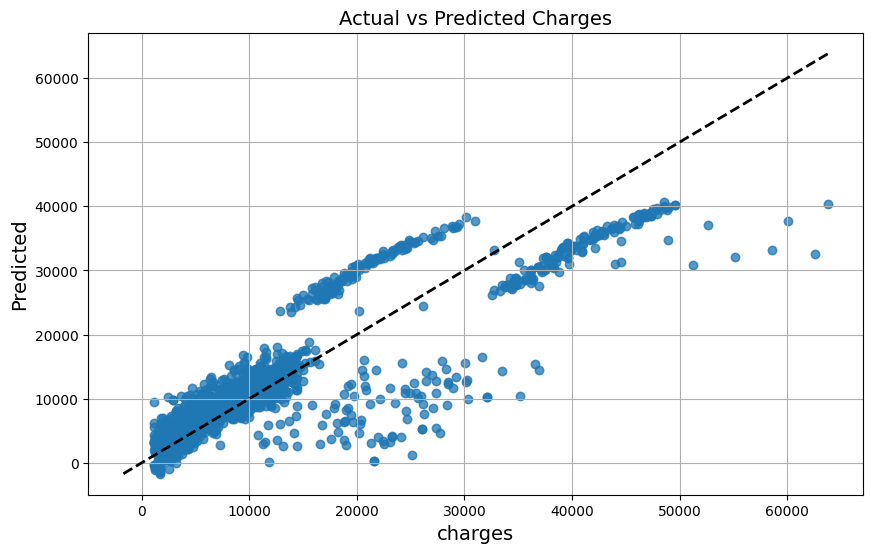

In [42]:
plt.figure(figsize=(10, 6))

plt.scatter(df_new[TARGET], df_new['pred'], alpha=0.5)

min_val = min(df_new[TARGET].min(), df_new['pred'].min())
max_val = max(df_new[TARGET].max(), df_new['pred'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)  

plt.xlabel(TARGET, fontsize=14)
plt.ylabel('Predicted',fontsize=14)
plt.title('Actual vs Predicted Charges', fontsize = 14)

plt.grid(True)
plt.show()


## Residual Plot

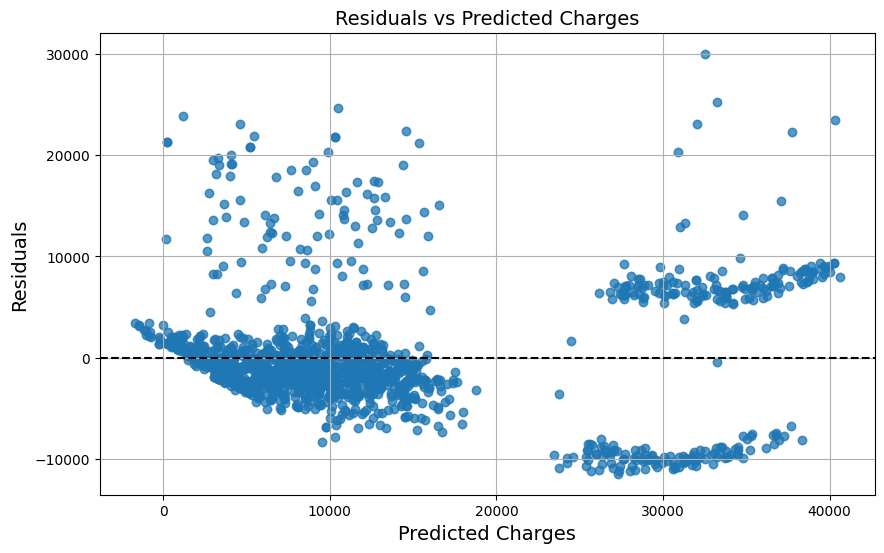

In [43]:
df_new['Residuals'] = df_new[TARGET] - df_new['pred']
plt.figure(figsize=(10, 6))

plt.scatter(df_new['pred'], df_new['Residuals'], alpha=0.5)

plt.axhline(y=0, color='k', linestyle='--')

plt.xlabel('Predicted Charges', fontsize=14)
plt.ylabel('Residuals', fontsize= 14)
plt.title('Residuals vs Predicted Charges', fontsize=14)
plt.grid(True)  #
plt.show()
